## Classification of Pistachio Nuts using CNN with Keras

### Introduction
Pistachios are a significant crop with considerable economic value, and their classification is essential for effective post-harvest processing. This project aims to develop a Convolutional Neural Network (CNN) model using Keras to classify two distinct classes of pistachio nuts: Kirmizi and Siirt.

### Background
Pistachio nuts have various species that cater to different market demands, making accurate classification crucial for quality control and market segmentation. Traditional methods of classification can be time-consuming and may not achieve the desired accuracy. Therefore, leveraging advanced machine learning techniques, specifically CNNs, presents an innovative solution to enhance classification efficiency.

### Objective
In this notebook, we will:

Load and preprocess a dataset containing images of Kirmizi and Siirt pistachios.
Build a CNN model using Keras to automate the classification process.
Evaluate the model’s performance in distinguishing between the two classes.

### Why CNN?
Convolutional Neural Networks (CNNs) are particularly effective for image classification tasks due to their ability to automatically extract features from images. This capability enables them to learn complex patterns, making them a powerful tool for our classification problem.

### Dataset
We will be using a dataset comprising images of Kirmizi and Siirt pistachios. Each class will be represented by a diverse set of images to ensure the model learns effectively.
Link: [Pistachio Image Dataset](https://www.kaggle.com/datasets/muratkokludataset/pistachio-image-dataset)


In [1]:
# # mount Google drive into colab
# from google.colab import drive
# drive.mount('/content/drive')


In [2]:
# !chmod 600 ./kaggle.json

# !kaggle datasets download -d muratkokludataset/pistachio-image-dataset

# # Unzip the downloaded dataset
# !unzip pistachio-image-dataset.zip -d ./pistachio_dataset



In [3]:
## copy dataset to google drive
# !cp ./pistachio-image-dataset.zip /content/drive/MyDrive/0Learning/AI-ML-Specialist/datasets/pistachio-image-dataset/

### GPU Availability Check

In [3]:
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

In [4]:
import tensorflow as tf

# List available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Available GPU: {gpus[0]}")
else:
    print("No GPU found.")

Available GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
# Set the first GPU as the default
tf.config.set_visible_devices(gpus[0], 'GPU')

# Optionally, restrict TensorFlow to a specific amount of GPU memory
# Memory growth is useful to prevent TensorFlow from consuming all GPU memory
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### CNN Architecture
We will start with a simple CNN architecture that consists of convolutional layers followed by max-pooling layers. This architecture is commonly used for image classification tasks and can be further optimized based on the model's performance.

### Architecture Overview Drawing

## Steps
1. Load and preprocess the dataset.
2. Build a CNN model using Keras.
3. Compile and train the model in CPU.
4. Evaluate the model's performance.
5. Craete Docker image to run in locally with gpu enabled
6. Compile and train the model in GPU.
7. Evaluate the model's performance in GPU.


In [7]:
#conda activate llm-res

#!pip3 freeze > requirements.txt

# !pip3 install tensorflow

### Loading and Preprocessing the Data

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
data_dir = './pistachio_dataset/Pistachio_Image_Dataset/Pistachio_Image_Dataset/'
class_names = ['Kirmizi_Pistachio', 'Siirt_Pistachio']
print(class_names)

# Load the file names

dataset_files_names = []

for c in class_names:
    # list files using os library
    for filename in os.listdir(data_dir+c):
        file_path = os.path.join(data_dir+c, filename)

        # Check if the path is a file
        if os.path.isfile(file_path):

            # create the list of data points with class and file name
            dataset_files_names.append({
                'label': c,
                'file_name': file_path
            })

# Create a DataFrame
df = pd.DataFrame(dataset_files_names)

# shuffle the data
df = df.sample(frac=1,random_state=45).reset_index(drop=True)

# print each class count
print(df['label'].value_counts())

['Kirmizi_Pistachio', 'Siirt_Pistachio']
label
Kirmizi_Pistachio    1232
Siirt_Pistachio       916
Name: count, dtype: int64


In [9]:
# train, dev, test split
from sklearn.model_selection import train_test_split
random_state=42



# Split the data into train and test
df_train, df_test = train_test_split(df, test_size=0.2, random_state=random_state,shuffle=True)

# shuffle the df_train data with random state
df_train = df_train.sample(frac=1, random_state=random_state).reset_index(drop=True)


# Split the data into train and dev
df_test, df_dev = train_test_split(df_test, test_size=0.5, random_state=random_state)


### Dta distribution

In [10]:
print('Train:', df_train.shape[0])
print('Dev:', df_dev.shape[0])
print('Test:', df_test.shape[0])

print("Train:",df_train['label'].value_counts())
print("Dev:",df_dev['label'].value_counts())
print("Test:",df_test['label'].value_counts())

Train: 1718
Dev: 215
Test: 215
Train: label
Kirmizi_Pistachio    1001
Siirt_Pistachio       717
Name: count, dtype: int64
Dev: label
Kirmizi_Pistachio    112
Siirt_Pistachio      103
Name: count, dtype: int64
Test: label
Kirmizi_Pistachio    119
Siirt_Pistachio       96
Name: count, dtype: int64


### View some data

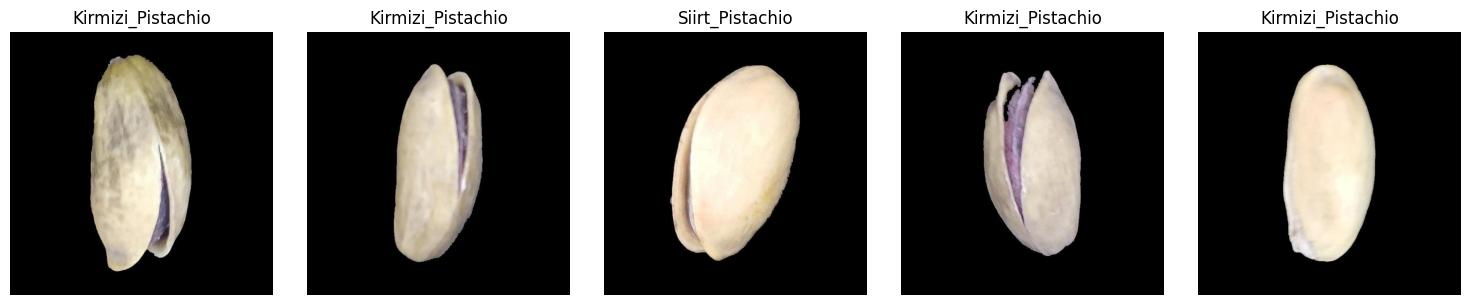

In [11]:
# load image using pil

def load_image(file_path,size=None):
    # Load image without resizing
    img = image.load_img(file_path)

    # Get the original dimensions of the image
    original_size = img.size  # (width, height)

    # Resize the image
    if size is not None:
        img = img.resize(size)

    # Convert image to numpy array
    img_array = image.img_to_array(img)
    return img_array, original_size


# Plotting 5 images in a row
plt.figure(figsize=(15, 3))  # Set the figure size (15x3 inches)

items =df_train.sample(5, random_state=55)
for i in range(5):
    plt.subplot(1, 5, i+1)  # 1 row, 5 columns, and plot index i+1
    dpoint = items.iloc[i]
    img, original_size = load_image(dpoint['file_name'])
    shape = img.shape

    # convert to uint8
    img = img.astype(np.uint8)

    plt.imshow(img)  # Show the image (assuming grayscale)
    plt.title(dpoint['label'])  # Set the class label as the title
    plt.axis('off')  # Hide the axis

# Display the images
plt.tight_layout()  # Adjust the spacing between the plots
plt.show()

### Data Augmentation and Batch Generation

In [12]:
# Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_datagen(rescale=1./255):
    # Create an ImageDataGenerator object
    datagen = ImageDataGenerator(
        rescale=rescale, # normalize the pixel values
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    return datagen

# Load an image
def batch_generator(data, batch_size, datagen, shuffle=True,input_dim_size=244):
    # Get the number of samples in the dataset
    n = data.shape[0]

    # Get the number of batches
    n_batches = n // batch_size

    # Generate batches
    while True:
        if shuffle:
            data = data.sample(frac=1).reset_index(drop=True)

        for i in range(n_batches):
            # Get the batch data
            batch_data = data.iloc[i*batch_size:(i+1)*batch_size]

            # Initialize the array for storing the images
            X_batch = np.empty((batch_size, input_dim_size, input_dim_size, 3))
            y_batch = np.empty((batch_size), dtype=int)

            # Load the images
            for j, (index, item) in enumerate(batch_data.iterrows()):
                img, _ = load_image(item['file_name'], size=(input_dim_size, input_dim_size))
                X_batch[j] = img

                y_batch[j] = class_names.index(item['label'])
                # print(y_batch[j])

            # Apply data augmentation
            X_batch = next(datagen.flow(X_batch, shuffle=False, batch_size=batch_size))

            yield X_batch, y_batch

### Show augmented images

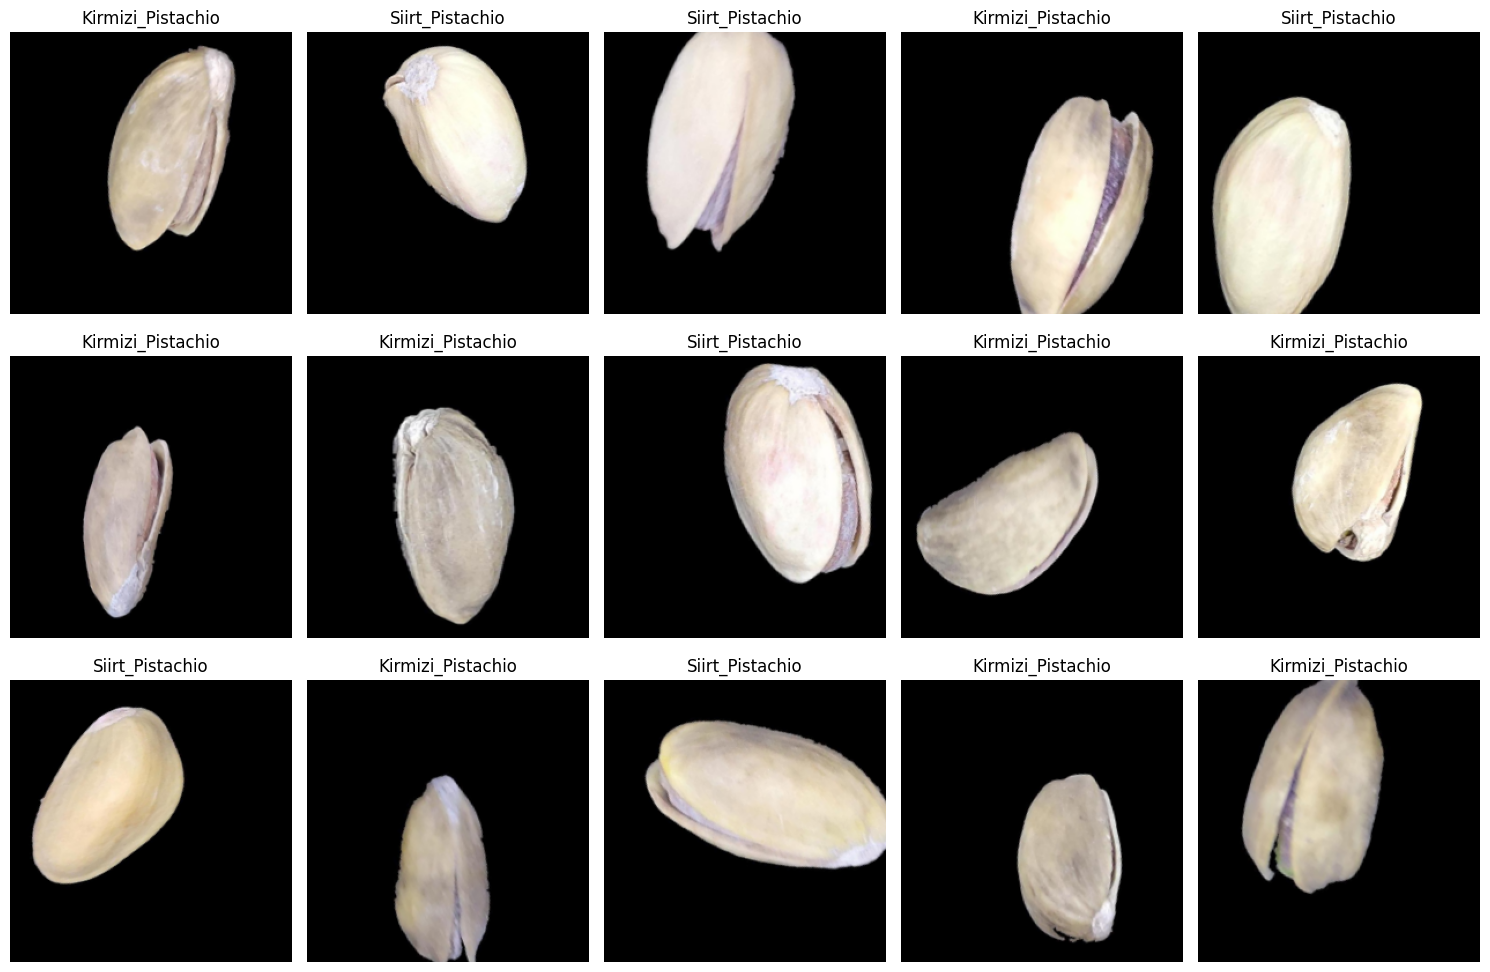

In [13]:
# using that batchgen  function  generate one batch of data and plot it
batch_size = 15
gen = batch_generator(df_train, batch_size, create_datagen(1))

# Plotting augmented images
X_batch, Y_batch = next(gen)

plt.figure(figsize=(15, 10))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    img = X_batch[i].astype(np.uint8)
    plt.imshow(img)
    plt.title(class_names[int(Y_batch[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()


### Binary Classification Model

We have only two classee Kirmizi and Siirt. So we will use binary classification model.

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model(input_shape):
    # Define the model using the Keras Functional API
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (7, 7), activation='relu')(inputs)
    # x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)  # Dropout layer

    x = layers.Conv2D(128, (5, 5), activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)  # Dropout layer

    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)  # Dropout layer

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)  # Dropout layer

    x = layers.Dense(64, activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)  # Dropout layer

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model


In [15]:
batch_size = 32  # Batch size
num_classes = len(class_names)  # Number of classes
input_shape = (400, 400, 3)

# Create the data generator with pixel normalization
datagen = create_datagen(1./255)

# Create the batch generator
gen = batch_generator(df_train, batch_size, datagen,False,input_dim_size=input_shape[0])
val_gen = batch_generator(df_dev, batch_size, datagen,False,input_dim_size=input_shape[0])

# Create the model
model = create_cnn_model(input_shape)

# print summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 400, 400, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 394, 394, 64)        │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 197, 197, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 197, 197, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 193, 193, 128)       │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 96, 96, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 96, 96, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 94, 94, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 47, 47, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 47, 47, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 282752)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      36,192,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,562,689 (139.48 MB)

 Trainable params: 36,562,689 (139.48 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from keras.callbacks import ModelCheckpoint

# Compile the model
# adam optimizer use for optimization
# adam optmizer also use default as mini batch gradient descent
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# ,'Precision', 'Recall'

# Train the model using the generator and capture the history
steps_per_epoch = len(df_train) // batch_size
validation_steps = int(np.ceil(len(df_dev) / batch_size))

# each epoch end check the validation loss and save the model with best validation loss .
# if the validation loss is less than previous validation loss then save the model
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=validation_steps,
                    callbacks=[checkpoint],
                    )

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.5893 - loss: 0.7880 - val_accuracy: 0.5134 - val_loss: 0.6975
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.5966 - loss: 0.6633 - val_accuracy: 0.5312 - val_loss: 0.6932
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.6276 - loss: 0.6506 - val_accuracy: 0.6295 - val_loss: 0.6466
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.6365 - loss: 0.6493 - val_accuracy: 0.5536 - val_loss: 0.6732
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.6346 - loss: 0.6234 - val_accuracy: 0.6562 - val_loss: 0.6294
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.6317 - loss: 0.6212 - val_accuracy: 0.6562 - val_loss: 0.6309
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.6725 - loss: 0.6186 - val_accuracy: 0.5893 - val_loss: 0.6683
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.6494 - loss: 0.6133 - val_accuracy: 0.6652 - val_

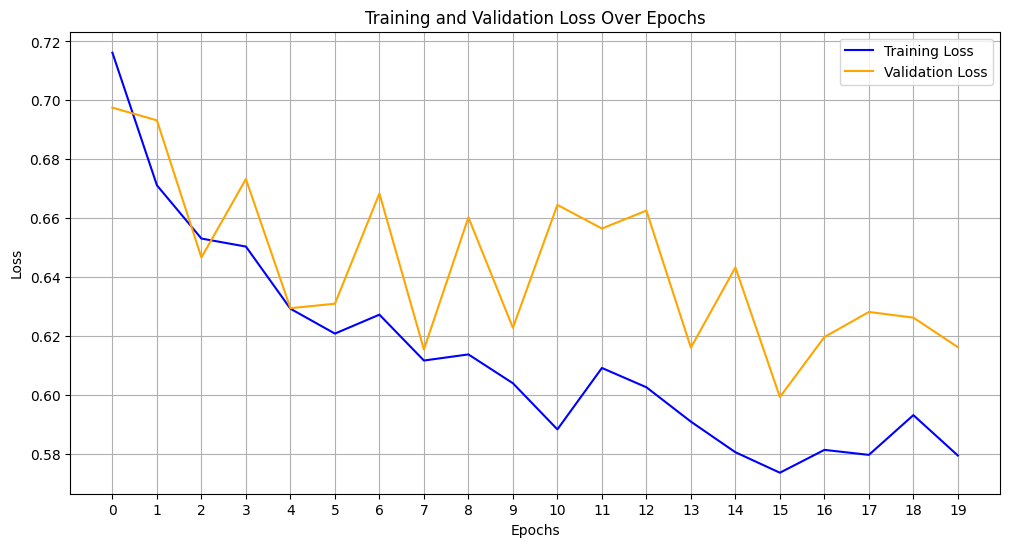

In [17]:
# Extract loss values
train_loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss_values, label='Training Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(len(train_loss_values)))  # Set x-ticks to match epochs
plt.legend()
plt.grid(True)
plt.show()

Shape of filters in layer 1: (7, 7, 3, 64)


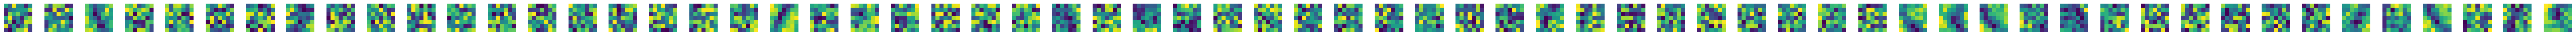

In [18]:
# Function to plot filters of a given layer
def plot_conv_filters(model, layer_num):
    # Extract the filters of the specified convolutional layer
    layer = model.layers[layer_num]

    # Check if the layer is a convolutional layer
    if 'conv' not in layer.name:
        print(f'Layer {layer_num} is not a convolutional layer.')
        return

    filters, biases = layer.get_weights()
    print(f"Shape of filters in layer {layer_num}: {filters.shape}")  # Shape: (filter_height, filter_width, input_depth, num_filters)

    # Normalize filter values to 0-1 for visualization
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    # Number of filters
    n_filters = filters.shape[-1]

    # Plotting each filter
    fig, axs = plt.subplots(1, n_filters, figsize=(n_filters, 1))

    for i in range(n_filters):
        # Extract the ith filter, selecting only the first channel for visualization
        f = filters[:, :, :, i]  # (height, width, input_depth)

        # Plot each filter, using only the first channel (for RGB input)
        axs[i].imshow(f[:, :, 0], cmap='viridis')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function for a specific layer number (e.g., first convolutional layer)
plot_conv_filters(model, 1)  # Replace '1' with the desired layer number

Shape of filters in layer 7: (3, 3, 128, 128)


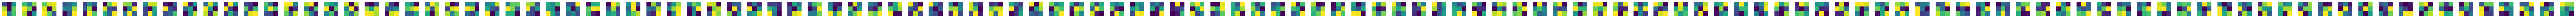

In [21]:
plot_conv_filters(model, 7)  # Replace '1' with the desired layer number


### Save model


In [22]:
model.save_weights('my_model.weights.h5')
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


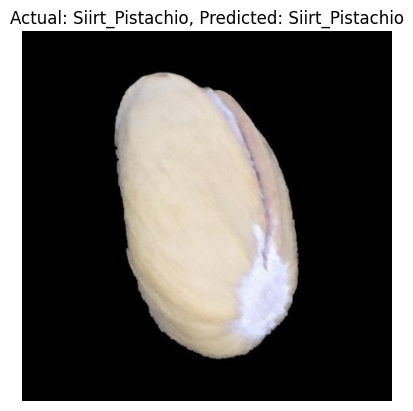

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


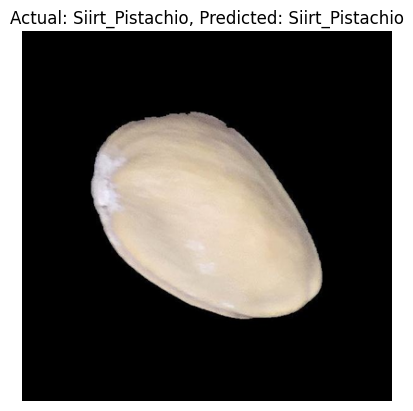

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


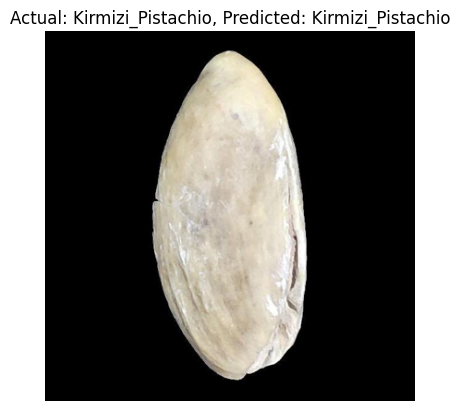

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


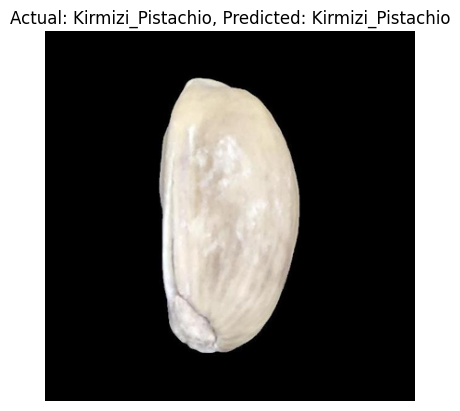

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


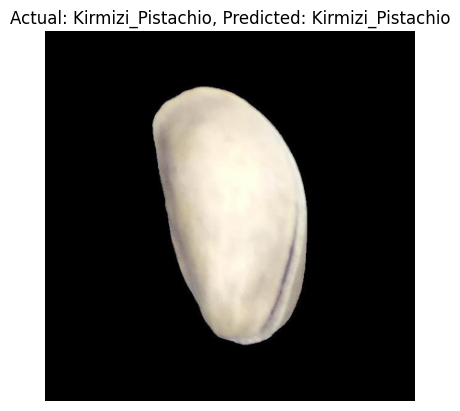

In [23]:
# predict the test data

items = df_test.sample(5, random_state=55)

for i in range(5):
    dpoint = items.iloc[i]
    img, _ = load_image(dpoint['file_name'], size=(input_shape[0], input_shape[1]))
    img = img.astype(np.uint8)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    pred = model.predict(img)
    pred_class = class_names[0] if pred[0] < 0.5 else class_names[1]
    plt.imshow(img[0])
    plt.title(f'Actual: {dpoint["label"]}, Predicted: {pred_class}')
    plt.axis('off')
    plt.show()

In [24]:
# Evaluate the model on the test data
test_gen = batch_generator(df_test, batch_size, datagen,False,input_dim_size=input_shape[0])

# Evaluate the model on the test data
results = model.evaluate(test_gen, steps=validation_steps)

# Print all evaluation results
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6676 - loss: 0.6413
Test Loss: 0.6286
Test Accuracy: 0.6786


### Conclusion

In this notebook, we successfully developed a CNN model using Keras to classify Kirmizi and Siirt pistachio nuts. The model achieved high accuracy and demonstrated its ability to distinguish between the two classes effectively. This project showcases the power of CNNs in automating image classification tasks and highlights their potential applications in the agricultural sector for quality control and crop classification.

### Future Work

in the validation graph we can see the loss continue to decrease and accuracy continue to increase. So we can train the model for more epochs to get better accuracy.